In [3]:
 
from google.colab import auth
auth.authenticate_user()


# **Interpreting the Evolution Factors of Basketball**
By Ava Wang, Michael P, Mochi Zang, Niming Wang, Urvashi Tripathi

Datasets: 
*   Games: [Kaggle link](https://www.kaggle.com/nathanlauga/nba-games)
*   Players: [Kaggle link](https://www.kaggle.com/justinas/nba-players-data)

*Source: NBA stats website*













## **General Summary**
The evolution of basketball and the NBA through shifts in training, equipment and technology has been significant. Through this analysis, we attempt to understand the factors that impact wins and how they can be made efficient.

We will analyze the impact of player demographic data and factors such as player start position, minutes played, field goals made (FGM), two/three pointers and free throws made and how they vary with player performance and scoring in games. Ultimately, the goal is to identify how scoring has evolved in the NBA from 1997 to 2020.



## **Real World Impact**
Data has become front and center in the NBA strategy world. Game plays, shooting strategies and injury risk prediction are just some of challenges NBA teams are already tackling through analytics. Case in point is the tremendous rise of 3 pointers in the NBA, primarily influened by analytics insights that pointed to greater value in 3 pointers vs. 2 pointers.

Arm chair experts remark that this shift is driven by wider adoption of data analytics in decision making.

Our analysis is takes this idea and focuses on understanding winning strategies and players that make a mark.




## **Data Overview**
We are using NBA games data that contains details from 1997 to 2020 that include game date, teams, points in the game amongst others.
The data also includes basketball metrics such as field goal percentage, three point percentage, assists and rebounds.
For supplementary analysis, we are also using the NBA players demographic data that includes details such as player age, height, draft details, average points scored, shooting efficiency.

## **Data Pre-Processing and Setup**
The NBA games data contains information on games played by team, year and season and includes sport stats such as total points and field goal percentage.


Let's take a look at the `game` data set

In [ ]:
%%bigquery --project ba-775-project-team-4
SELECT * 
FROM 
 `ba-775-project-team-4.NBA.games`
LIMIT 10

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2003-10-24,10300116,Final,1610612753,1610612762,2003,1610612753,None,None,None,None,None,None,1610612762,None,None,None,None,None,None,0
1,2003-10-24,10300108,Final,1610612737,1610612764,2003,1610612737,None,None,None,None,None,None,1610612764,None,None,None,None,None,None,0
2,2003-10-24,10300109,Final,1610612738,1610612751,2003,1610612738,None,None,None,None,None,None,1610612751,None,None,None,None,None,None,0
3,2003-10-24,10300113,Final,1610612759,1610612745,2003,1610612759,None,None,None,None,None,None,1610612745,None,None,None,None,None,None,0
4,2003-10-24,10300112,Final,1610612749,1610612765,2003,1610612749,None,None,None,None,None,None,1610612765,None,None,None,None,None,None,0
5,2003-10-24,10300110,Final,1610612756,1610612757,2003,1610612756,None,None,None,None,None,None,1610612757,None,None,None,None,None,None,0
6,2003-10-24,10300111,Final,1610612743,1610612754,2003,1610612743,None,None,None,None,None,None,1610612754,None,None,None,None,None,None,0
7,2003-10-24,10300114,Final,1610612746,1610612744,2003,1610612746,None,None,None,None,None,None,1610612744,None,None,None,None,None,None,0
8,2003-10-24,10300115,Final,1610612747,1610612758,2003,1610612747,None,None,None,None,None,None,1610612758,None,None,None,None,None,None,0
9,2003-10-23,10300103,Final,1610612761,1610612739,2003,1610612761,None,None,None,None,None,None,1610612739,None,None,None,None,None,None,0


The data is comprised of 21 features for each for each game ID. Below are some specifications and summary statistics about the data we would like call out:



*   TEAM_ID_home: The ID of the home team 
*   PTS_home: Total number of points scored by the home team in the game 
*   FG_PCT_home: Field Goal Percentage of the home team
*   FT_PCT_home: Free Throw Percentage of the home team
*   FG3_PCT_home: Three Point Percentageof the home team
*   AST_home: Assists of the home team
*   REB_home: Rebounds of the home team

Corresponding statistics exist in the data for the away teams as well

Additionally, we plan to show offensive contributions by type of field goals and their long term trends by joining onto the 'games_details' data set. Fields of relevance are: 



*   FGM: Field Goals Made
*   FGA: Field Goals Attempted
*   FG3M: Three Pointers Made
*   FG3A: Three Pointers Attempted
*   FTM: Free Throws Made
*   FTA: Free throws Attempted














`players` dataset gives us an overview of each player's demographic information and their performance: 

In [ ]:
%%bigquery --project ba-775-project-team-4
SELECT * 
FROM 
 `ba-775-project-team-4.Players.Players`
LIMIT 10

,int64_field_0,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,10705,Jeremy Pargo,GSW,34.0,187.96,99.336648,Gonzaga,USA,2009,0,0,3,8.3,1.0,2.7,2.4,0.024,0.048,0.268,0.557,0.308,2019-20
1,11063,Josh Magette,ORL,30.0,185.42,72.574720,Alabama Huntsville,USA,2012,0,0,8,1.5,0.8,0.6,2.4,0.022,0.128,0.226,0.378,0.238,2019-20
2,2776,Yao Ming,HOU,22.0,226.06,134.263232,None,China,2002,1,1,82,13.5,8.2,1.7,2.2,0.099,0.223,0.222,0.570,0.104,2002-03
3,3246,Yao Ming,HOU,23.0,228.60,140.613520,None,China,2002,1,1,82,17.5,9.0,1.5,3.6,0.093,0.220,0.252,0.586,0.090,2003-04
4,3661,Yao Ming,HOU,24.0,228.60,140.613520,None,China,2002,1,1,80,18.3,8.4,0.8,2.0,0.102,0.215,0.264,0.614,0.048,2004-05
5,4281,Yao Ming,HOU,25.0,228.60,140.613520,None,China,2002,1,1,57,22.3,10.2,1.5,1.4,0.093,0.248,0.298,0.592,0.092,2005-06
6,4795,Yao Ming,HOU,26.0,228.60,140.613520,None,China,2002,1,1,48,25.0,9.4,2.0,9.3,0.076,0.238,0.331,0.601,0.115,2006-07
7,5277,Yao Ming,HOU,27.0,228.60,140.613520,None,China,2002,1,1,55,22.0,10.8,2.3,4.1,0.098,0.227,0.272,0.587,0.116,2007-08
8,5483,Yao Ming,HOU,28.0,228.60,140.613520,None,China,2002,1,1,77,19.7,9.9,1.8,7.8,0.099,0.232,0.263,0.618,0.096,2008-09
9,6374,Yao Ming,HOU,30.0,228.60,140.613520,None,China,2002,1,1,5,10.2,5.4,0.8,-14.3,0.081,0.220,0.242,0.579,0.077,2010-11


##**Data Deep Dive**

Lets take a closer look at the details our dataset covers. This would include teams/games/players covered, timeframe, and high level trends such as top performers 

How many distinct games exist in our dataset? 

In [ ]:
%%bigquery --project ba-775-project-team-4
SELECT count(game_id) AS number_of_games, count(distinct game_id) AS number_of_distinct_games
FROM 
 `ba-775-project-team-4.NBA.games`


,number_of_games,number_of_distinct_games
0,24677,24622


How many players are covered in this dataset?

In [ ]:
%%bigquery --project ba-775-project-team-4
SELECT
  COUNT(DISTINCT player_name) AS number_of_players
FROM
  `ba-775-project-team-4.Players.Players`

,number_of_players
0,2333


How many teams are covered in this dataset?

In [ ]:
%%bigquery --project ba-775-project-team-4
SELECT
  COUNT(DISTINCT TEAM_ID) AS number_of_distinct_tems
FROM
  `ba-775-project-team-4.NBA.teams`

,number_of_distinct_tems
0,30


How many years of data is covered within this dataset?

In [ ]:
%%bigquery --project ba-775-project-team-4
SELECT
  COUNT(DISTINCT EXTRACT (year
    FROM
      GAME_DATE_EST)) AS number_of_years
FROM
  `ba-775-project-team-4.NBA.games`

,number_of_years
0,19


  What NBA teams win the most at home?

In [ ]:
%%bigquery --project ba-775-project-team-4
SELECT
  t.NICKNAME,
  SUM(g.HOME_TEAM_WINS) AS home_wins
FROM
  `ba-775-project-team-4.NBA.games` AS g
LEFT JOIN
  `ba-775-project-team-4.NBA.teams` AS t
ON
  g.HOME_TEAM_ID = t.TEAM_ID
GROUP BY
  t.NICKNAME
ORDER BY
  home_wins DESC

,NICKNAME,home_wins
0,Spurs,662
1,Heat,584
2,Celtics,554
3,Nuggets,553
4,Rockets,551
5,Warriors,547
6,Mavericks,546
7,Lakers,544
8,Jazz,527
9,Pacers,526


For each year, which teams win at home the most?

In [ ]:
%%bigquery --project ba-775-project-team-4
SELECT
  EXTRACT(year from g.GAME_DATE_EST) AS year,
  t.NICKNAME,
  SUM(g.HOME_TEAM_WINS) AS home_wins
FROM
  `ba-775-project-team-4.NBA.games` AS g
LEFT JOIN
  `ba-775-project-team-4.NBA.teams` AS t
ON
  g.HOME_TEAM_ID = t.TEAM_ID
GROUP BY
  t.NICKNAME,year
HAVING home_wins > 0
ORDER BY
  home_wins DESC

,year,NICKNAME,home_wins
0,2012,Heat,54
1,2008,Celtics,54
2,2009,Lakers,53
3,2015,Warriors,53
4,2012,Thunder,52
...,...,...,...
564,2003,Wizards,5
565,2014,76ers,5
566,2020,Pistons,4
567,2003,Magic,3


For each year, which teams win away the most?

In [ ]:
%%bigquery --project ba-775-project-team-4
SELECT
  EXTRACT(year from g.GAME_DATE_EST) as year,
  t.NICKNAME,
  COUNT(g.HOME_TEAM_WINS) AS away_wins
FROM
  `ba-775-project-team-4.NBA.games` AS g
LEFT JOIN
  `ba-775-project-team-4.NBA.teams` AS t
ON
  g.HOME_TEAM_ID = t.TEAM_ID
WHERE g.HOME_TEAM_WINS = 0
GROUP BY
  t.NICKNAME, year
ORDER BY
  away_wins DESC

,year,NICKNAME,away_wins
0,2012,Hornets,42
1,2014,76ers,39
2,2016,76ers,38
3,2008,Clippers,36
4,2016,Lakers,35
...,...,...,...
564,2020,76ers,5
565,2011,Bulls,5
566,2011,Spurs,4
567,2021,Jazz,4


What are NBA scoring leaders by season?

In [ ]:
%%bigquery --project ba-775-project-team-4
SELECT player_name, pts as score_leader,season from  `ba-775-project-team-4.Players.Players` as a
where pts = (select MAX(pts)
FROM
 `ba-775-project-team-4.Players.Players` as b
where a.season = b.season)
order by a.season 

,player_name,score_leader,season
0,Michael Jordan,29.6,1996-97
1,Michael Jordan,28.7,1997-98
2,Allen Iverson,26.8,1998-99
3,Shaquille O'Neal,29.7,1999-00
4,Allen Iverson,31.1,2000-01
5,Allen Iverson,31.4,2001-02
6,Tracy McGrady,32.1,2002-03
7,Tracy McGrady,28.0,2003-04
8,Allen Iverson,30.7,2004-05
9,Kobe Bryant,35.4,2005-06


What are each year's average total points per game?

In [ ]:
%%bigquery --project ba-775-project-team-4
SELECT
  EXTRACT(year
  FROM
    GAME_DATE_EST) AS year,
  AVG(PTS_home+PTS_away) AS average_total_point_per_game
FROM
  `ba-775-project-team-4.NBA.games`
GROUP BY
  year
ORDER BY
  AVG(PTS_home+PTS_away) 

,year,average_total_point_per_game
0,2003,184.475269
1,2004,188.379151
2,2012,192.825949
3,2005,193.944251
4,2006,195.553411
5,2007,196.871795
6,2013,197.085196
7,2011,197.679781
8,2008,198.470180
9,2010,199.734637


Is there a home advantage? Before using regression, we simply compare each team's times of winning as the home team and times of winning as the away team.

In [ ]:
%%bigquery --project ba-775-project-team-4
SELECT
  t.NICKNAME,
  SUM(g.HOME_TEAM_WINS) AS home_wins,
  COUNT(g.HOME_TEAM_WINS)-SUM(g.HOME_TEAM_WINS) AS away_wins,
  SUM(g.HOME_TEAM_WINS)- (COUNT(g.HOME_TEAM_WINS)-SUM(g.HOME_TEAM_WINS)) as difference
FROM
  `ba-775-project-team-4.NBA.games` AS g
LEFT JOIN
  `ba-775-project-team-4.NBA.teams` AS t
ON
  g.HOME_TEAM_ID = t.TEAM_ID
GROUP BY
  t.NICKNAME
ORDER BY
  home_wins

,NICKNAME,home_wins,away_wins,difference
0,Timberwolves,363,422,-59
1,Knicks,366,411,-45
2,Hornets,367,372,-5
3,Kings,388,393,-5
4,Nets,410,400,10
5,Wizards,421,372,49
6,76ers,428,376,52
7,Pelicans,429,358,71
8,Magic,435,380,55
9,Suns,456,358,98


In [ ]:
%%bigquery --project ba-775-project-team-4
SELECT
  t.TEAM_ID,
  SUM(g.HOME_TEAM_WINS) AS home_wins,
  COUNT(g.HOME_TEAM_WINS)-SUM(g.HOME_TEAM_WINS) AS away_wins,
  SUM(g.HOME_TEAM_WINS)- (COUNT(g.HOME_TEAM_WINS)-SUM(g.HOME_TEAM_WINS)) as difference
FROM
  `ba-775-project-team-4.NBA.games` AS g
LEFT JOIN
  `ba-775-project-team-4.NBA.teams` AS t
ON
  g.HOME_TEAM_ID = t.TEAM_ID
GROUP BY
  t.TEAM_ID
ORDER BY
  home_wins

,TEAM_ID,home_wins,away_wins,difference
0,1610612750,363,422,-59
1,1610612752,366,411,-45
2,1610612766,367,372,-5
3,1610612758,388,393,-5
4,1610612751,410,400,10
5,1610612764,421,372,49
6,1610612755,428,376,52
7,1610612740,429,358,71
8,1610612753,435,380,55
9,1610612756,456,358,98



This is a preliminary exploration of the datasets. Having familiarized ourselves with the data, we hope to dive deeper and try to answer some more questions:


*   Is home court advantage real? Correlation for each team between winning and court
*   How have the different point scoring shots varied over time? (3>2)
*   How has points contribution varied by player height over time? 
*   Has offensive productivity gone up overall? (Are players today more skilled?)
*   How has player diversity varied over time? (Are more international players entering the NBA?)







 



##**Analysis**  

**Impact on wins/performace of:** 











###**1. Player attributes**
Answering questions such as: Changes in players' physical features, overall diversity variation in the NBA


1. Average player height, weight, age in winning team for every season 

In [ ]:
%%bigquery --project ba-775-project-team-4
SELECT season, avg(player_height)as avg_height, avg(player_weight)as avg_weight,avg(age)as avg_age
from  `ba-775-project-team-4.Players.Players` 
group by season
order by season 


,season,avg_height,avg_weight,avg_age
0,1996-97,200.994830,100.526270,27.963719
1,1997-98,200.619499,100.265530,28.084282
2,1998-99,200.903007,100.639563,28.002278
3,1999-00,200.920959,100.735741,28.107306
4,2000-01,200.752154,100.842450,28.097506
5,2001-02,201.017909,101.288124,27.672727
6,2002-03,201.520514,102.032765,27.530374
7,2003-04,201.315113,101.635395,27.457014
8,2004-05,201.245733,101.697477,27.297414
9,2005-06,200.920655,101.340178,26.890830


2. Increase in non american players in the league across seasons/year

In [ ]:
%%bigquery --project ba-775-project-team-4
SELECT season, count(player_name) as non_US_players,
from `ba-775-project-team-4.Players.Players`
where country not like 'USA'
group by season
order by season

,season,non_US_players
0,1996-97,9
1,1997-98,14
2,1998-99,22
3,1999-00,24
4,2000-01,40
5,2001-02,51
6,2002-03,62
7,2003-04,61
8,2004-05,74
9,2005-06,80


### **2. Game Statistics**
Answering questions such as the variation between 3 pointers and two pointers and the relationship between overall winning and home court wins, change in total points over the years



1. Point variation (3 pointer and 2 pointer) over time

In [ ]:
%%bigquery --project ba-775-project-team-4
select season,sum(FG3M) as total_3,sum(FGM-FG3M) as total_2 
from (select a.*, b.SEASON as season
from `ba-775-project-team-4.NBA.detail` as a
left join `ba-775-project-team-4.NBA.games` as b
on a.GAME_ID= b.GAME_ID)
group by season
order by season desc


,season,total_3,total_2
0,2020,31305.0,69869.0
1,2019,30430.0,70169.0
2,2018,31217.0,81320.0
3,2017,28996.0,79995.0
4,2016,27069.0,82144.0
5,2015,24179.0,83240.0
6,2014,22337.0,83469.0
7,2013,22020.0,84661.0
8,2012,20251.0,84419.0
9,2011,14028.0,65979.0


2. Pointers attempted per game over the years


In [ ]:
%%bigquery --project ba-775-project-team-4
select avg(total_3A) as avg_3pa_per_game, season
from (
select season,GAME_ID,sum(FG3A) as total_3A
from (select a.*, b.SEASON as season
from `ba-775-project-team-4.NBA.detail` as a
left join `ba-775-project-team-4.NBA.games` as b
USING(GAME_ID))
group by GAME_ID,season
order by GAME_ID)
group by season
order by season desc

,avg_3pa_per_game,season
0,74.764553,2020
1,68.712329,2019
2,64.040639,2018
3,58.163531,2017
4,54.035587,2016
5,48.491525,2015
6,45.114245,2014
7,43.091801,2013
8,39.976056,2012
9,36.652174,2011


3. pointer percentage every season

In [4]:
%%bigquery --project ba-775-project-team-4
select sum(fg3m)/sum(fg3a) as percentage, season
from (select season,GAME_ID,sum(FG3M) AS fg3m, SUM(FG3A) as fg3a
from (select a.*, b.SEASON as season
from `ba-775-project-team-4.NBA.detail` as a
left join `ba-775-project-team-4.NBA.games` as b
USING(GAME_ID))
group by GAME_ID,season
order by GAME_ID)
group by season
order by season desc

,percentage,season
0,0.363783,2020
1,0.356858,2019
2,0.353742,2018
3,0.360728,2017
4,0.356546,2016
5,0.352135,2015
6,0.349168,2014
7,0.358095,2013
8,0.356745,2012
9,0.346679,2011


In [5]:
%%bigquery --project ba-775-project-team-4
select season,GAME_ID,sum(FG3M) AS fg3m, SUM(FG3A) as fg3a
from (select a.*, b.SEASON as season
from `ba-775-project-team-4.NBA.detail` as a
left join `ba-775-project-team-4.NBA.games` as b
USING(GAME_ID))
group by GAME_ID,season
order by GAME_ID

,season,GAME_ID,fg3m,fg3a
0,2003,10300001,3.0,15.0
1,2003,10300002,6.0,28.0
2,2003,10300003,8.0,15.0
3,2003,10300004,7.0,24.0
4,2003,10300005,7.0,19.0
...,...,...,...,...
24518,2020,52000111,28.0,75.0
24519,2020,52000121,25.0,65.0
24520,2020,52000131,15.0,44.0
24521,2020,52000201,29.0,69.0


2.3 Has offensive play gone up over the years?

In [6]:
%%bigquery --project ba-775-project-team-4
SELECT
  EXTRACT (year
  FROM
    g.GAME_DATE_EST)AS year,
  AVG(g.REB_home) as Rebound_cross_teams
FROM
  `ba-775-project-team-4.NBA.games` AS g
LEFT JOIN
  `ba-775-project-team-4.NBA.teams` AS t
ON
  g.HOME_TEAM_ID = t.TEAM_ID
GROUP BY
  year
ORDER BY
  year

,year,Rebound_cross_teams
0,2003,43.391398
1,2004,42.882625
2,2005,42.303833
3,2006,41.638870
4,2007,42.114672
5,2008,42.484743
6,2009,42.018908
7,2010,42.085196
8,2011,41.883060
9,2012,42.779747


1.Home vs away score for each team for each year

In [7]:
%%bigquery --project ba-775-project-team-4
SELECT
  EXTRACT(year
  FROM
    g.GAME_DATE_EST) AS year,
  t.NICKNAME,
  SUM(g.HOME_TEAM_WINS) AS home_wins,
  COUNT(g.HOME_TEAM_WINS)-SUM(g.HOME_TEAM_WINS) AS away_wins,
  SUM(g.HOME_TEAM_WINS)- (COUNT(g.HOME_TEAM_WINS)-SUM(g.HOME_TEAM_WINS)) AS difference
FROM
  `ba-775-project-team-4.NBA.games` AS g
LEFT JOIN
  `ba-775-project-team-4.NBA.teams` AS t
ON
  g.HOME_TEAM_ID = t.TEAM_ID
GROUP BY
  t.NICKNAME,
  year
ORDER BY
  year

,year,NICKNAME,home_wins,away_wins,difference
0,2003,Magic,3,17,-14
1,2003,Hawks,5,13,-8
2,2003,Celtics,8,13,-5
3,2003,Spurs,14,8,6
4,2003,Bucks,10,7,3
...,...,...,...,...,...
564,2021,Warriors,25,12,13
565,2021,Hawks,24,11,13
566,2021,76ers,29,7,22
567,2021,Pelicans,17,18,-1


##**Report Summary**

### After what felt like a million SQL queries and a thousand tableau filters, we have been able to establish the trends we set out to achieve. Below are some insights we present from our analysis.

[Tableau Dashboard Link](https://public.tableau.com/app/profile/urvashi.tripathi/viz/Interpretingtheevolutionfactorsofbasketball/Dashboard1?publish=yes)



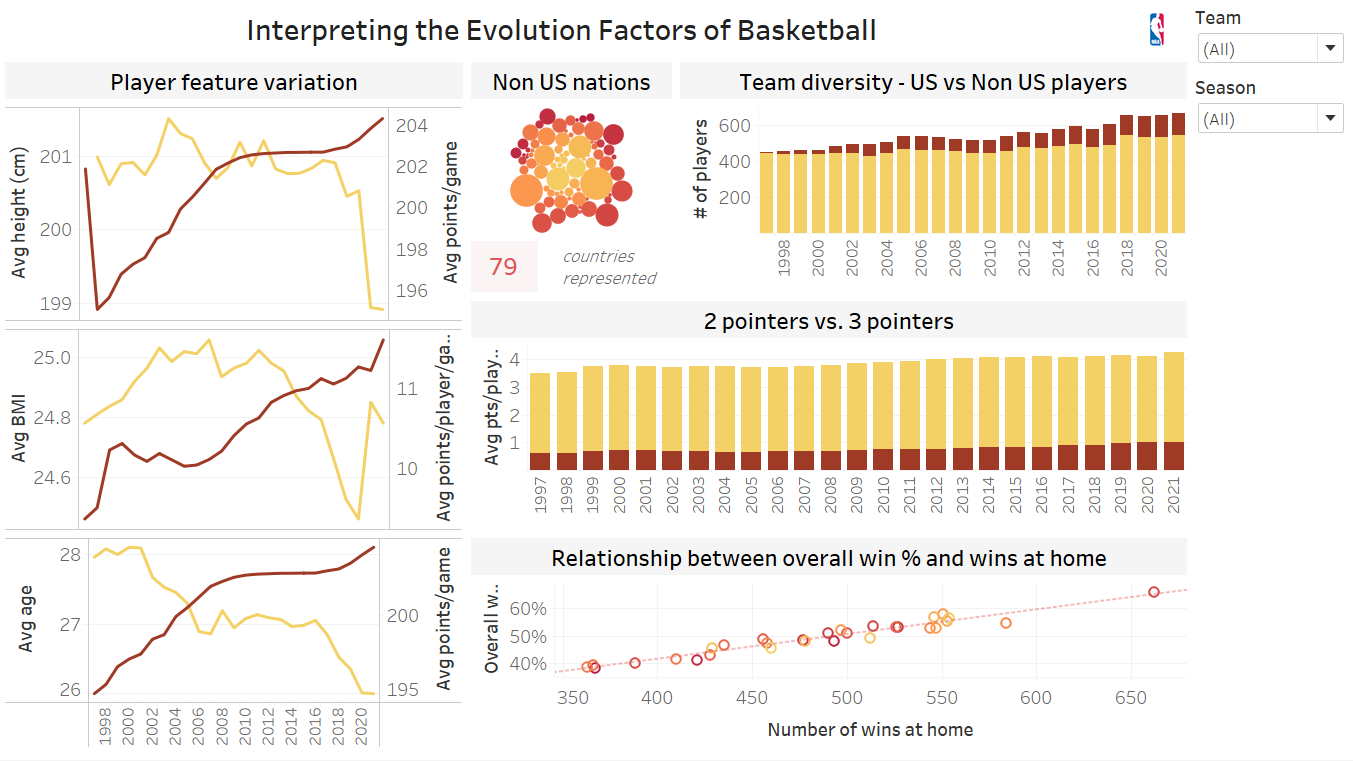

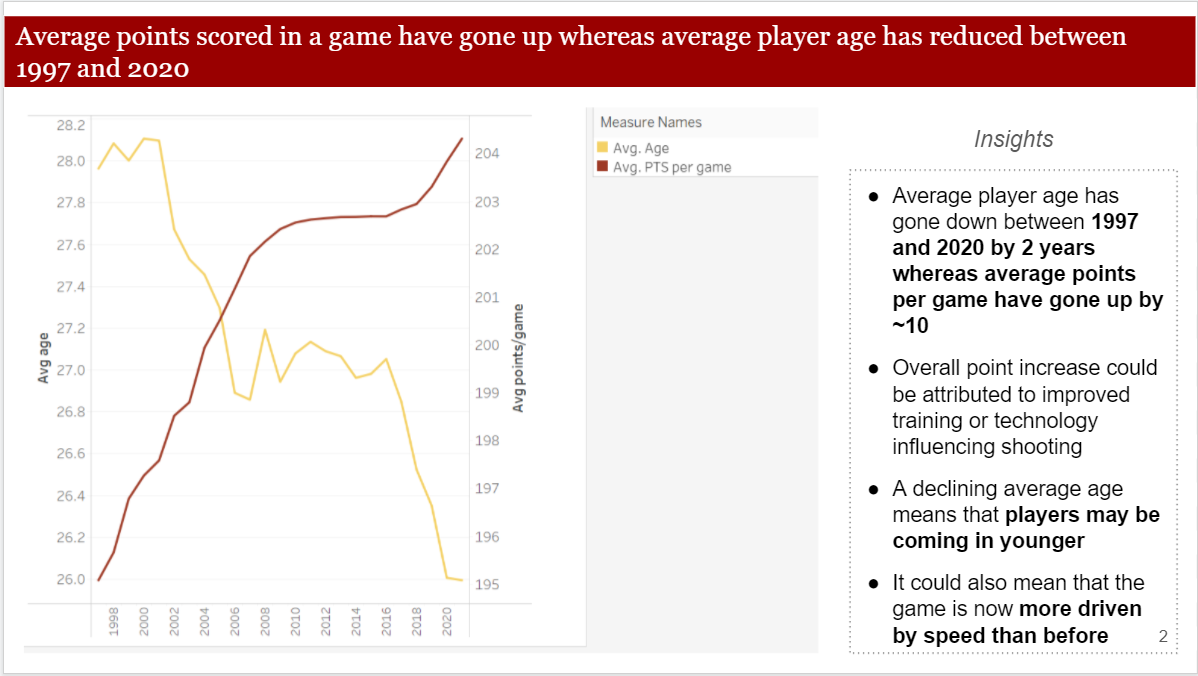

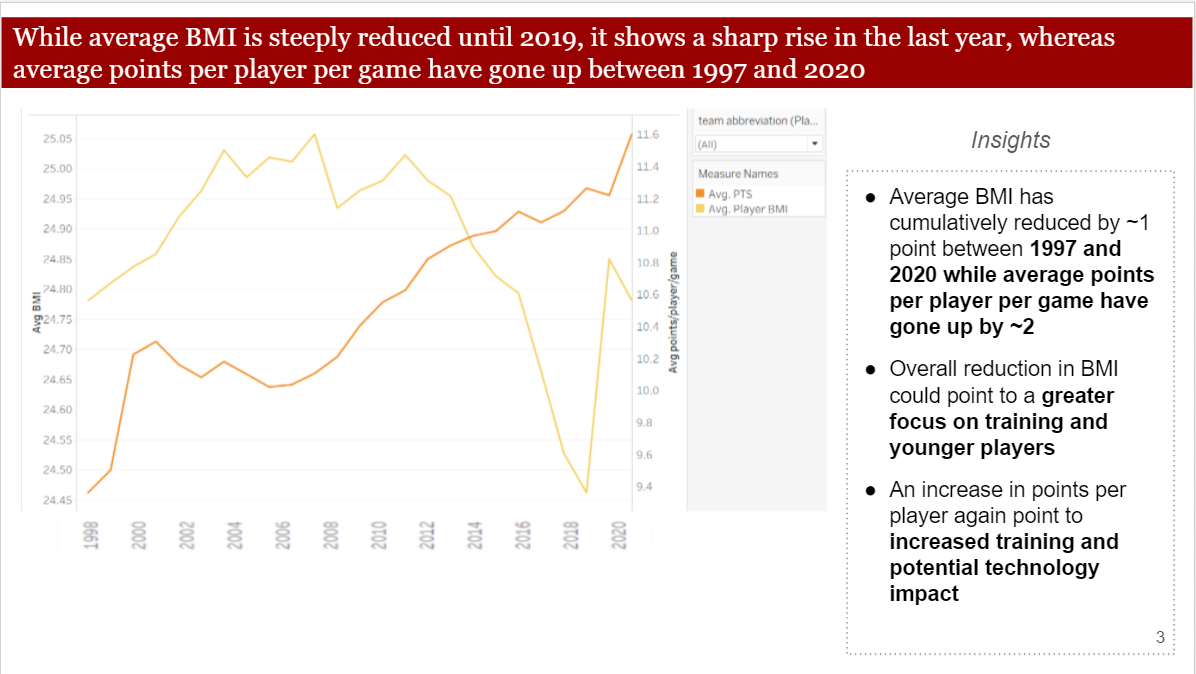

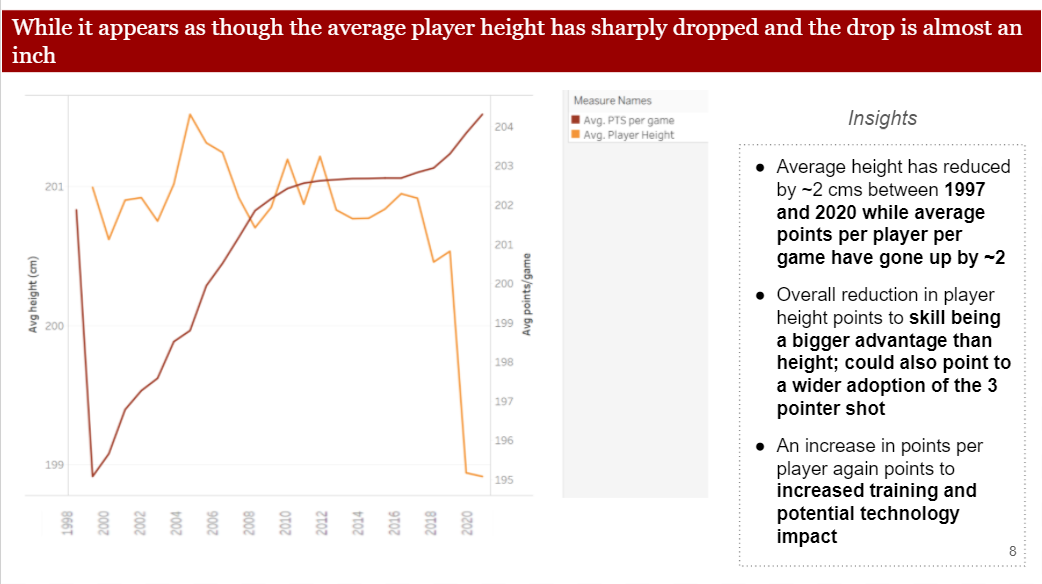

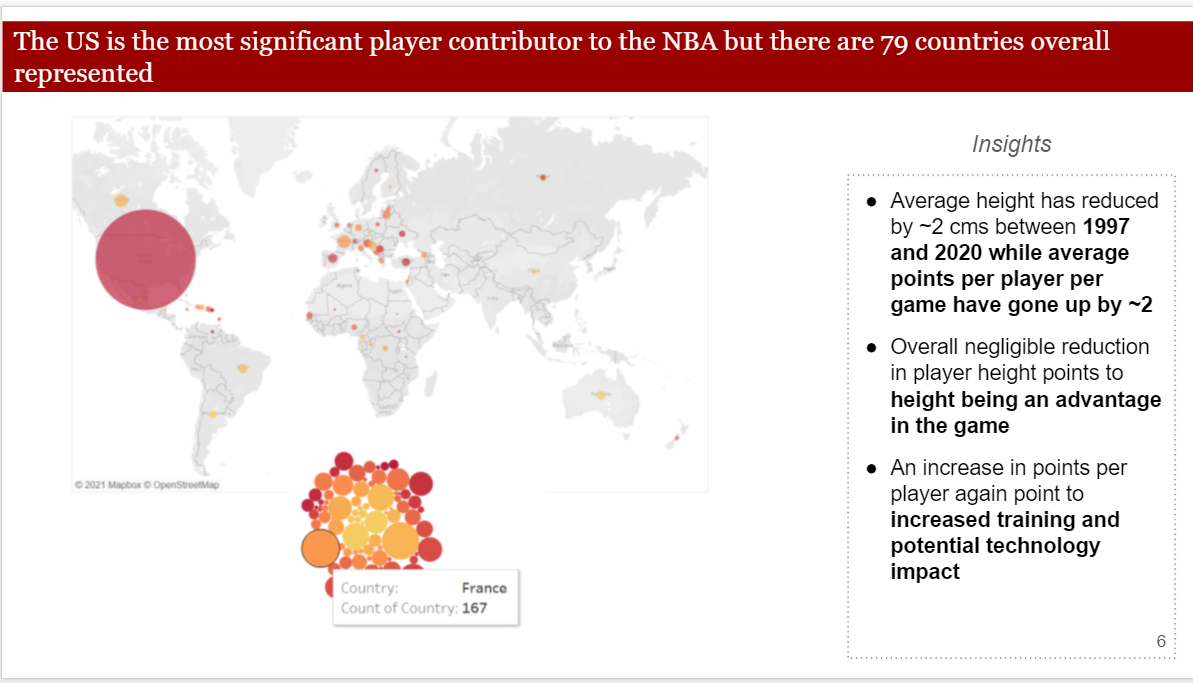

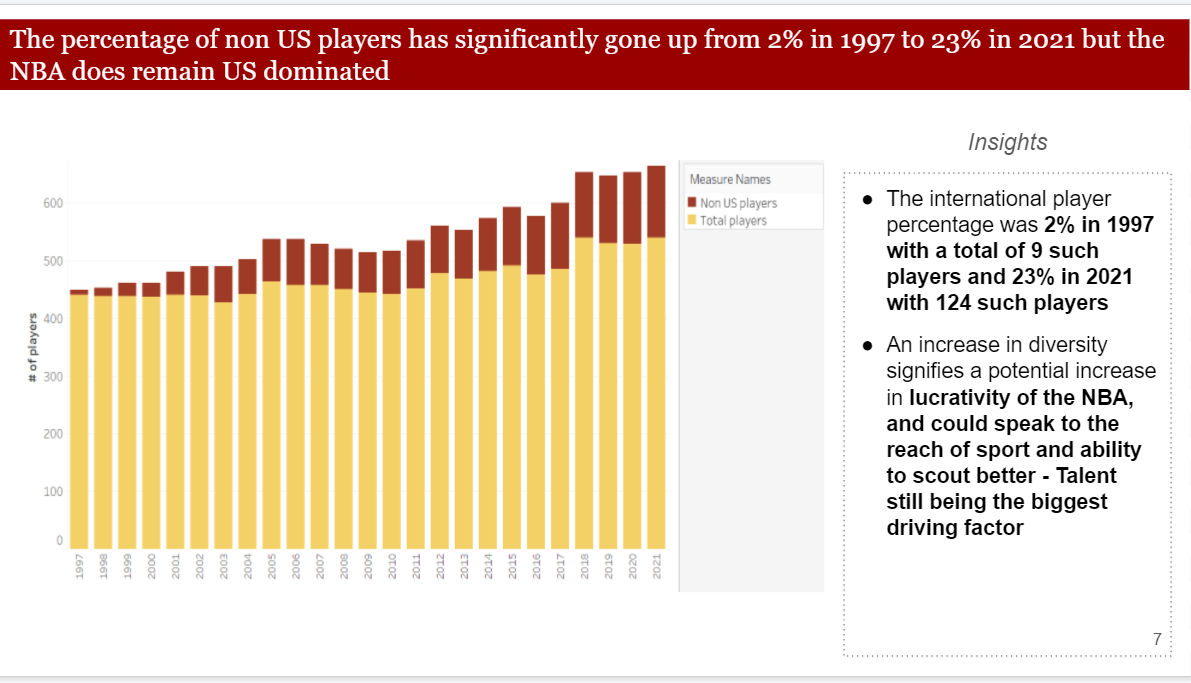

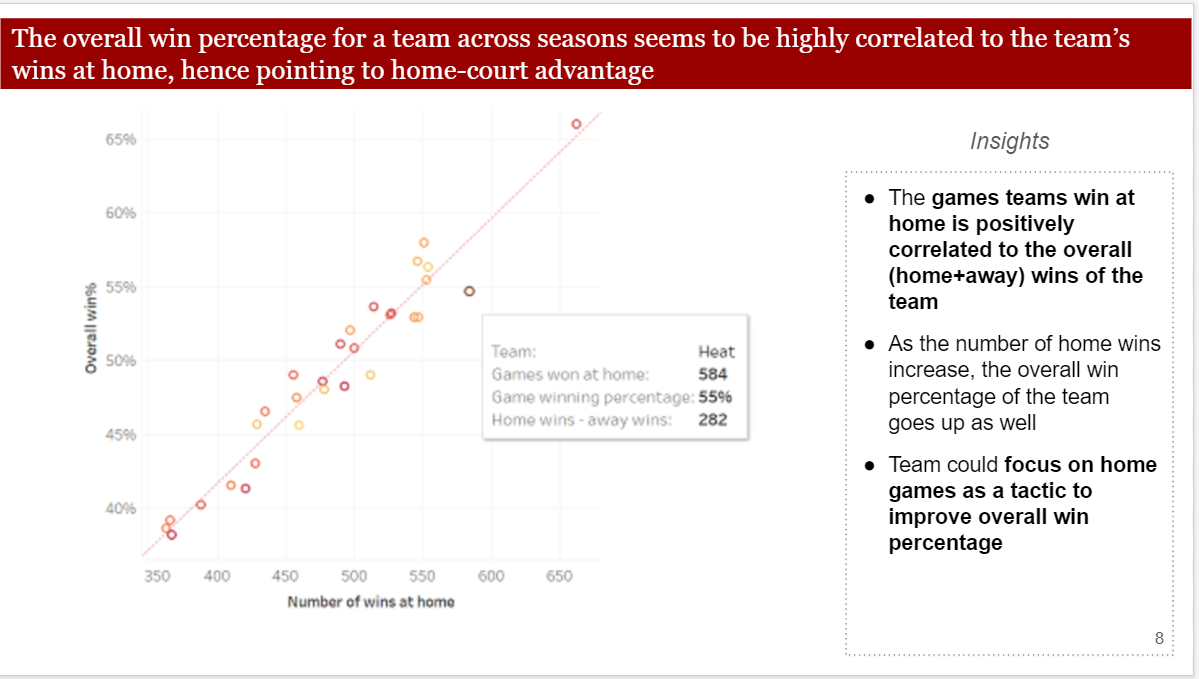

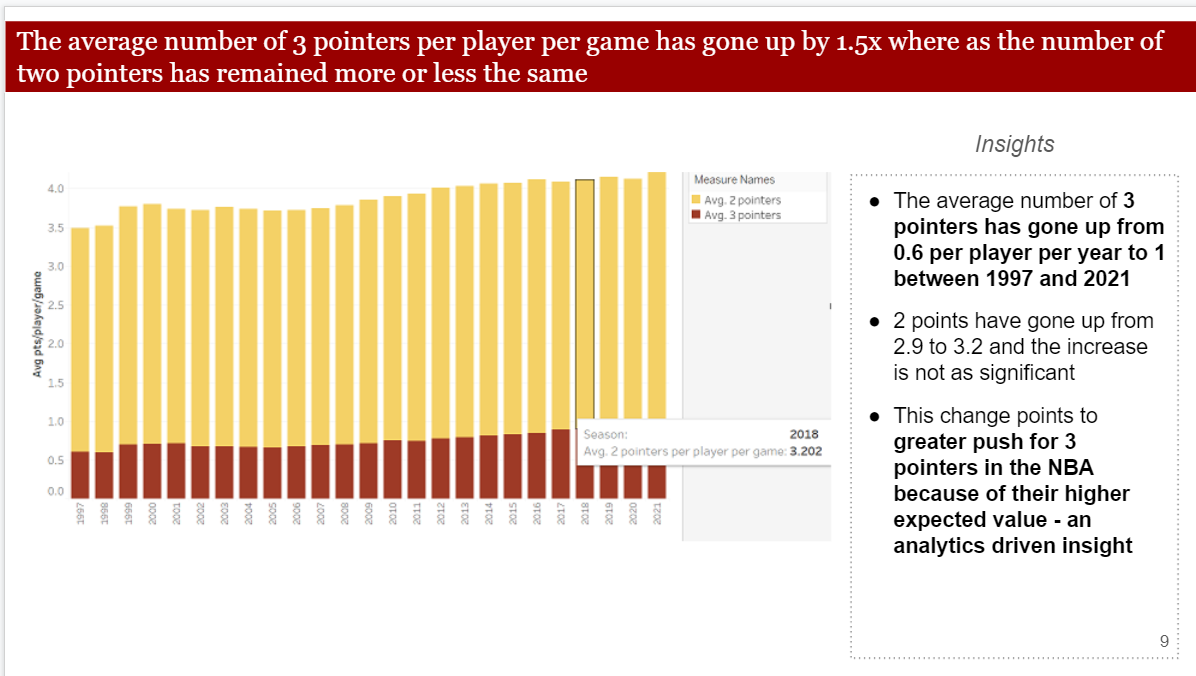

##**Conclusion**

###Through the insights generated in this dashboard, we definitely see a big shift in the NBA becoming more speed and offense driven. 
###We also interpret an increased focus on training through the reduced BMI and slightly lower height as well as the overall increase in average points in every game.
###Technology makes its role clear through the increase in 3 pointers over 2 in our data. 

###Additional scope that can be covered through this data is team level analysis to understand how tops teams differ from the rest.



